In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

import secrets
from PIL import Image
from ase.io import read
from ase.visualize import view

#!git clone https://github.com/ahoust17/DataGenSTEM.git
#sys.path.append('./DataGenSTEM/DataGenSTEM')
sys.path.append('/Users/austin/Documents/GitHub/DataGenSTEM/DataGenSTEM')
import data_generator as dg

In [2]:
xtal = read('./crystal_files/SrTiO3.cif') * (40,40,3)
view(xtal)

<Popen: returncode: None args: ['/Users/austin/miniconda3/envs/pyTEMlib/bin/...>

In [3]:
# Define the image size in Angstroms
positions = xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)


In [4]:
n_images = 100
crop_size = 512
pixel_size = 0.078125 # Angstrom/pixel, determines number of points, aka resolution of maps.  the xtal determines the fov
n_crops = 10 
used_seeds = []

In [5]:
# Set numpy randomizer
master_seed = secrets.randbits(128)
while master_seed in used_seeds:
    master_seed = secrets.randbits(128)
used_seeds.append(master_seed)
rng = np.random.default_rng(master_seed)

# Set random params
# --------------------------------------------------
phonon_sigma = rng.uniform(0.05, 0.15)
rotation = 15 #rng.uniform(0, 360)
atom_var = rng.normal(loc = 0.175, scale = 0.01)
airy_disk_size = 1
shot_noise = rng.uniform(0.6, 0.9)
magnification_var = rng.uniform(0.2, 0.35)
crop_param_seed = rng.integers(0, 1000000)
# --------------------------------------------------

In [6]:
# Make xtal (with random rotations and vacancies)
rot_xtal = dg.get_xtal_matrix(xtal = xtal, 
                              n_cells = (1,1,1), 
                              rotation = rotation, 
                              n_vacancies = 10, 
                              phonon_sigma = phonon_sigma, 
                              axis_extent = axis_extent)

In [7]:
potential = dg.get_pseudo_potential(xtal = rot_xtal,
                                    pixel_size = pixel_size,
                                    sigma = atom_var,
                                    axis_extent = axis_extent)
potential /= np.max(potential)


(-0.5, 2002.5, 2002.5, -0.5)

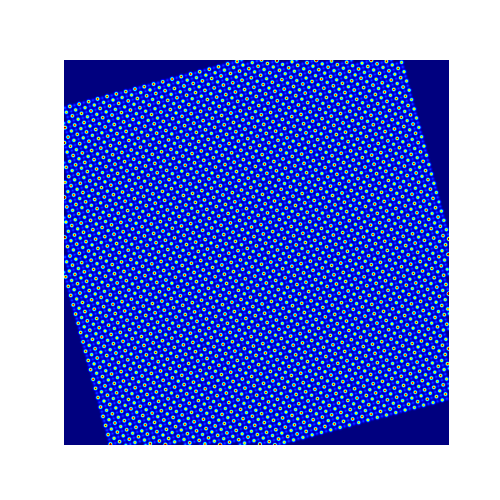

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))
ax.imshow(potential, cmap='jet', vmin=0, vmax=0.5)
ax.axis('off')

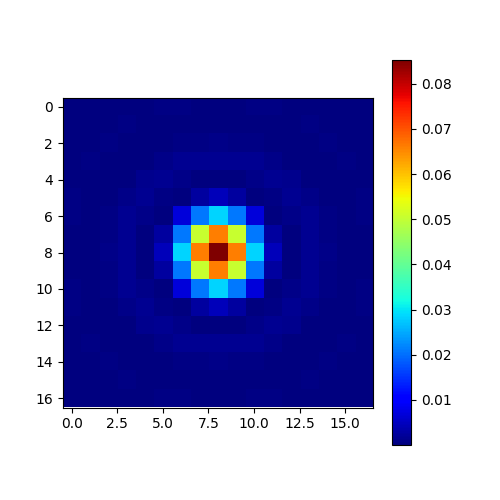

In [9]:
# Make point spread function
psf = dg.get_point_spread_function(airy_disk_radius = airy_disk_size, size = 8)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))
ax.imshow(psf, cmap='jet')
fig.colorbar(ax.imshow(psf, cmap='jet'), ax=ax)

In [12]:
# Make image, masks and add shot noise
perfect_image = dg.convolve_kernel(potential, psf)
noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = shot_noise)
masks = dg.get_masks(rot_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='binary')

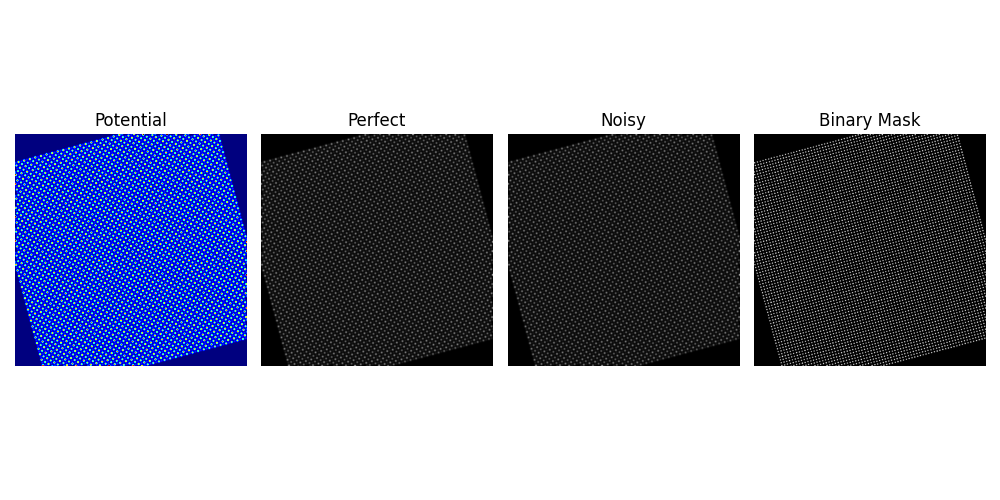

In [13]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.ravel()

ax[0].set_title('Potential')
ax[0].imshow(potential, cmap='jet', vmax=0.5)
ax[1].set_title('Perfect')
ax[1].imshow(perfect_image, cmap='gray')
ax[2].set_title('Noisy')
ax[2].imshow(noisy_image, cmap='gray')

ax[3].set_title('Binary Mask')
ax[3].imshow(masks, cmap='gray')


for ax in ax:
    ax.axis('off')
fig.tight_layout()


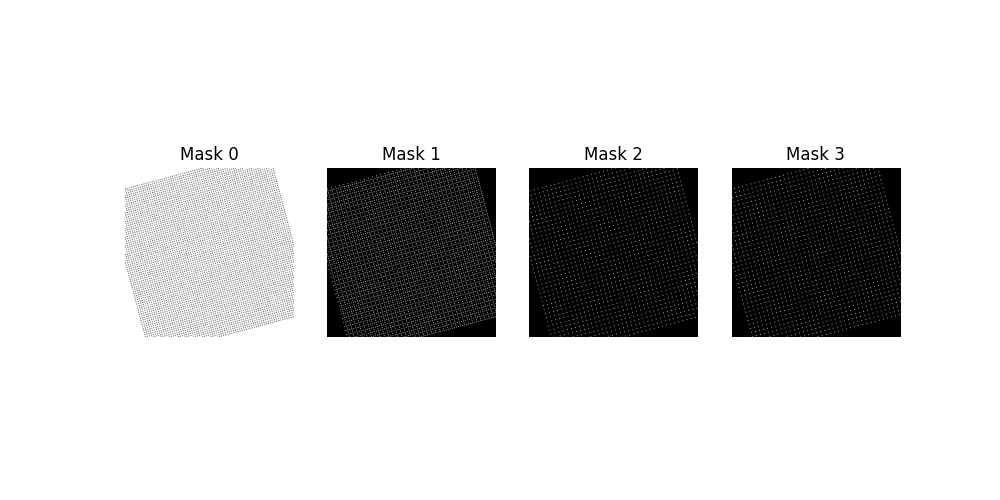

In [18]:
masks = dg.get_masks(rot_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='one_hot')

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 5))  

ax = ax.ravel()
for i in range(4):
    ax[i].imshow(masks[i,:,:], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Mask {i}')

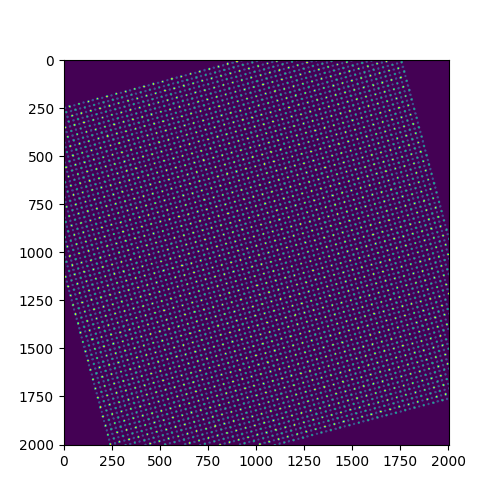

In [20]:
masks = dg.get_masks(rot_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='integer')

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))  

ax.imshow(masks, cmap='viridis')

In [13]:
# Crop and zoom
batch_ims = dg.shotgun_crop(noisy_image, crop_size = 512, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
batch_ims = batch_ims.reshape(-1,crop_size,crop_size)

batch_masks = dg.shotgun_crop(masks_l1, crop_size = 512, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
batch_masks = batch_masks.reshape(-1,len(masks_l1),crop_size,crop_size)
batch_masks = (batch_masks > 0.5).astype(int) # binarize the masks

NameError: name 'masks_l1' is not defined

In [ ]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
